<a href="https://colab.research.google.com/github/blackTieV2/ZEIT8042/blob/main/ZEIT8042Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Lab 1 - Question 1: Set `ebx` to 1337

### Step 1: Assembly Code

Opened and checked the assembly code in a file named 'shellcode.asm': No errors were seen and apprared to be correct.

```assembly
section .data
    hello: db '1337', 10

section .text
    global _start

_start:
    mov ebx, 1337
```

### Step 2: Assemble and Link the Shellcode

In terminal and navigate to the directory containing `shellcode.asm`. ./shellcode/1
 Then, ran the following commands to assemble and link the shellcode:

```sh
nasm -f elf shellcode.asm -o shellcode.o
ld -m elf_i386 -o shellcode shellcode.o
```

### Step 3: Extract Shellcode Bytes

Used `objdump` to extract the shellcode bytes:

```sh
objdump -d shellcode.o | grep '[0-9a-f]:' | grep -oP '\s\K[0-9a-f]{2}' | tr -d '\n' | sed 's/\(..\)/\\x\1/g'
```

This gave the following output, which is the shellcode in byte format:

```
\xbb\x39\x05\x00\x00
```


Here is a screenshot of the Setps 2 and 3 and the output:

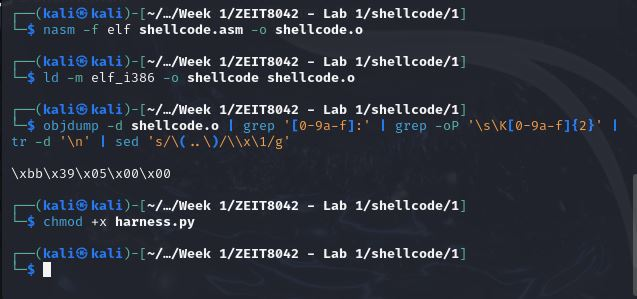

In [2]:
from IPython.display import Image
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC1.JPG')

### Step 4: Create a Python Harness

Created a Python script named `harness.py` with the following content:

```python
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import socket

def main():
    s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    s.connect(("localhost", 8888))

    # Insert the extracted shellcode here
    shellcode = b"\xbb\x39\x05\x00\x00"

    print("Sending shellcode (" + str(len(shellcode)) + " bytes)")
    s.send(shellcode)

if __name__ == "__main__":
    main()
```

### Step 5: Fix Line Endings

As I was copying from my host machine in to the kali VM, I had the following error. I fixed the issues with line endings by converting the script to Unix-style line endings:

```sh
sed -i 's/\r$//' harness.py
```



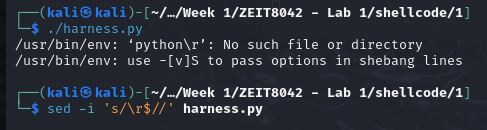

In [5]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC2.JPG')


### Step 6: Made the Script Executable

Make the Python script executable:

```sh
chmod +x harness.py
```

### Step 7: Ran the Shellcode Server and Test the Script


1. **Start the Shellcode Server**: In a seperate terminal window Started the shellcode-server
   ```sh
   ./bin/shellcode-server
   ```

2. **Run the Python Harness**: In the ./shellcode/1 folder:
   ```sh
   ./harness.py
   ```

### Expected Output

Received the following output, indicating that the shellcode was successfully sent:

```
Sending shellcode (5 bytes)
```


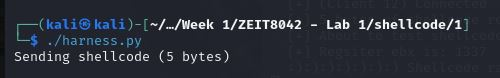

In [6]:
Image('/content/drive/MyDrive/ZEIT8042/Screenshots/Lab1-Q1-SC3.JPG')


### 🎯 Summary

- **Objective**: Write and test shellcode to set `ebx` to 1337.
- **Steps**:
  1. Write the assembly code and save it as `shellcode.asm`.
  2. Assemble and link the shellcode.
  3. Extract the shellcode bytes using `objdump`.
  4. Create a Python harness to send the shellcode.
  5. Fix any line ending issues.
  6. Make the Python script executable.
  7. Start the shellcode server and run the Python script.
